In [ ]:
'''
HOW TO USE:

Run "ONE TIME RUNS" once to load all dependencies and functions

Change modelname to appropriate .pth file

Change mixedaudio to your desired mixed audio

Run Audio results and processedmix
'''

#ONE TIME RUNS

##Dependencies

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import librosa
from IPython.display import Audio

## Model

In [11]:
'''
Initial convolutional layers
Time Length = 50
Spectrogram Filter Banks = 257(?)
input Structure (Time, Frequency, Channels, Batch)
Needs to be Batch, Channel, Frequency, Time form to work
'''

class ConvLayer(nn.Module):
    def __init__(self, input_dim, output_dim, activation=nn.ReLU):
        super(ConvLayer, self).__init__()
        self.convLayer = nn.Sequential(
            nn.Conv2d(input_dim, input_dim, (3, 3), stride=(1,1), padding = (1,0), dtype=torch.float), #Frequency dim padding only not clear how much
            nn.BatchNorm2d(input_dim, track_running_stats=True),
            activation()
        )
        self.asymStride = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, (3, 3), stride=(2, 1), padding = (1,0), dtype=torch.float), #Frequency dim padding only not clear how much
            nn.BatchNorm2d(output_dim, track_running_stats=True),
            activation()
        )
    def forward(self, x):
        x = self.convLayer(x)
        #print(x.shape)
        x = self.asymStride(x)
        #print(x.shape)
        return x

class FullCon(nn.Module):
    def __init__(self, input_dim, output_dim, activation=nn.ReLU):
        super(FullCon, self).__init__()
        self.full = nn.Sequential(
            nn.Linear(input_dim, output_dim, dtype=torch.float),
            nn.BatchNorm1d(output_dim, track_running_stats=True),
            activation()
        )
    def forward(self, x):
        x = self.full(x)
        return x

class Head(nn.Module):
    def __init__(self, input_dim, output_dim, activation=nn.ReLU):
        super(Head, self).__init__()
        self.head = nn.Sequential(
            nn.Linear(input_dim, output_dim, dtype=torch.float),
            activation()
        )
    def forward(self, x):
        x = self.head(x)
        return x

class BeamSep(nn.Module):
    def __init__(self):
        super(BeamSep, self).__init__()
        self.conv1=ConvLayer(10, 32) #8 input channels(change to # of beamspace input channels) Should be 15? I believe
        self.conv2=ConvLayer(32, 64)
        self.conv3=ConvLayer(64, 128)

        self.pool=nn.AvgPool2d((1,38)) #average along time axis (38)
        #Looks like the paper averages everything once and keeps freq the same
        self.flatten = nn.Flatten(start_dim=1)
        self.final1=FullCon(4224, 257) #Change 2048, to appropriate out size
        self.final2=Head(257, 257, nn.Sigmoid)

    def forward(self, x):
      x = self.conv1(x)
      #print(x.shape)
      x = self.conv2(x)
      #print(x.shape)
      x = self.conv3(x)
      #print(x.shape)
      x = self.pool(x)
      #print(x.shape)
      x = self.flatten(x)
      #print(x.shape)
      x = self.final1(x)
      #print(x.shape)
      x = self.final2(x)
      #print(x.shape)

      return x

##Beamspace Loader

In [29]:
import os
import numpy as np
import scipy.signal as sp
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile
pi = np.pi
eps = np.finfo(np.float32).eps
fs = 44100
# Functions
log_power = lambda x: 20*np.log10(np.abs(x+eps))
rad_to_deg = lambda x: 180*x/pi
segment_size = 50

a = 0.10 # array radius (m)
N = 8 # number of mics in UCA
channel_idx = -1+np.array([[1, 3, 5, 7, 9, 11, 13, 15,],
                           [2, 4, 6, 8, 10, 12, 14, 16]], dtype=int).reshape((2*N)) # Channel numbers corresponding to recorded WAV data
pi = np.pi
eps = np.finfo(np.float32).eps
# UCA beamspace transform parameters
Nphi = 8 # azimuthal beam count
Ntheta = 3 # elevational beam count

def recover_RIR(rir):
    rir[8] = rir[9]
    rir[11] = rir[10]
    return rir

def beamspace_manifold(X, a=0.10, N=8, Nphi=8, Ntheta=3, n_fft=2048, c0=343, fs=44100):
    F = 1+n_fft//2 # number of frequency bins
    T = X.shape[-1] # time slice length
    phibins = np.linspace(0, 2*pi, Nphi+1)[:-1] # azimuthal discretization
    thetabins = np.linspace(pi/6, 5*pi/6, Ntheta+2)[1:-1] # elevational discretization
    N_indices = np.concatenate([[0], np.linspace(N-1, 1, N-1)]) # indices corresponding to 1st column of complex weight matrix
    Y = np.zeros((F, Ntheta, Nphi, N, T), dtype=complex)
    for f_idx in range(F): # loop over all frequency bins
        f = f_idx*fs/n_fft
        k = 2*pi*f/c0
        w = np.array([np.outer(-k*a*np.sin(thetabins), np.cos(phibins-(2*pi*n/N))) for n in N_indices]) # complex weight vector for each angle at given frequency
        FT_X = np.fft.fft(X[:, f_idx], n=N, axis=0)
        FT_W = np.fft.fft(w, n=N, axis=0).swapaxes(-1, -2)
        if np.mean(np.abs(FT_W)) > eps: FT_W = FT_W/np.abs(np.max(FT_W))
        Y[f_idx] = np.array([np.fft.ifft(FT_W*FT_X[:, t][:, np.newaxis, np.newaxis]) for t in range(T)], dtype=complex).T # circular convolution (Hadamard product) across all time windows
    Y = np.transpose(Y, (2, 1, 0, 4, 3))
    Y = np.mean(Y, axis=-1) # add responses from all channels
    return Y

def stft(x, frame_len=2048, frame_step=512):
    return sp.stft(x, fs=44100, nperseg=frame_len, noverlap=(frame_len-frame_step))[-1]

def istft(x, frame_len=2048, frame_step=512, input_len=None):
    _reconstructed = sp.istft(x, fs=44100, noverlap=(frame_len-frame_step))[1].astype('float32' if x.dtype == 'complex64' else 'float64')
    if input_len is None:
        return _reconstructed
    else:
        rec_len = len(_reconstructed)
        if input_len <= rec_len:
            return _reconstructed[:input_len]
        else:
            return np.append(_reconstructed, np.zeros((input_len - rec_len,), dtype=x.dtype))

def segment_Y(Y): # segment beamspace manifold for training blocks
    Y_len = segment_size * (Y.shape[3]//segment_size)
    return np.reshape(Y[:, :, :, 0:Y_len], (Y.shape[0], Y.shape[1], Y.shape[3]//segment_size, Y.shape[2], segment_size))

def segment_mask(mask):
    return np.reshape(mask, (mask.shape[1]//segment_size, mask.shape[0], segment_size))

##Preprocessing Step

In [13]:
def prepFinal(chunk):
        #print(chunk.shape)
        data = np.concatenate((chunk[:, 0, 0, :, :], chunk[:, 0, 1, :, :],chunk[:, 1, 1, :, :],chunk[:, 0, 2, :, :],chunk[:, 7, 1, :, :]), axis = 0)
        data = np.asarray(data, dtype=complex)
        data = np.concatenate((data.real, data.imag), axis=0)
            #beamspace transform, removing 0 HZ
        #print(data.shape)
        data = np.expand_dims(data , axis = 0)
        x = torch.from_numpy(np.asarray(data, dtype = float)).float()

        return x

## Other Dependencies

In [42]:
def loadpth(modelname):
    model = BeamSep()
    model.load_state_dict(torch.load(modelname, map_location=torch.device('cpu'))['model_state_dict'])
    model.eval()
    return model

In [43]:
def SeperationAlgorithm(mixedaudio, modelname):
    mix, _ = librosa.load(mixedaudio, sr=fs,  mono=False)
    #Recovering Broken Mics
    mix = recover_RIR(mix)
    #Normalization Step
    for channel in range(16):
      mix[channel] = mix[channel]/np.max(np.abs(mix[channel]))

    #STFT, Beamtransform
    spectrogram3 = stft(mix, frame_len=512, frame_step=256)

    X = spectrogram3[channel_idx]
    print(X.shape)
    Y1 = beamspace_manifold(X[:N], a, N, Nphi, Ntheta, n_fft=512)
    Y2 = beamspace_manifold(X[N:], a, N, Nphi, Ntheta, n_fft=512)
    Y = (Y1+Y2)/2
    Yseg = segment_Y(Y)
    Y_len = Yseg.shape[2] * Yseg.shape[4]

    beam_spect = Yseg.reshape((Yseg.shape[0], Yseg.shape[1], Yseg.shape[3], Y_len))[4, 0]

    #Preprocessing Beamspace Transform for Masker
    Ypad = np.pad(Y, ((0,0),(0,0),(0,0),(25,25)),'constant', constant_values=(0))
    Ypad = np.expand_dims(Ypad, axis = 0)

    #make mask.shape the nearest 50 units
    limit = spectrogram3.shape[2] - spectrogram3.shape[2] % 50
    maskgen = np.empty((Y.shape[2],limit), dtype=float)
    model = loadpth(modelname)
    with torch.inference_mode():
      for segment in range(limit):
          x = prepFinal(Ypad[:, :, :, :, segment:segment+50])
          #print(x.shape)
          maskgen[:, segment] = model(x).cpu().detach().numpy()
          del x

    print(maskgen.shape)
    plt.imshow(maskgen)

    mixmasked = np.multiply(beam_spect, maskgen)
    beamformed_audio = istft(mixmasked, 512, 256)
    yhat_beamed = beamformed_audio/np.max(beamformed_audio)

    return yhat_beamed, mix


#Running

(16, 257, 869)
(257, 850)


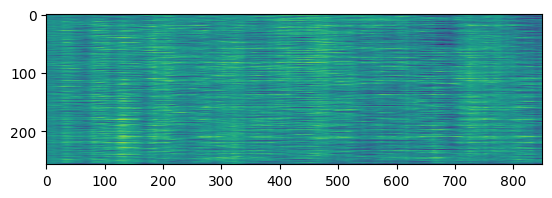

In [51]:
modelname = "AudioMaskerCircular-MAG257.pth"
mixedaudio = "both_speakers.wav"
result, processedmix = SeperationAlgorithm(mixedaudio, modelname)

In [52]:
Audio(result, rate = 44100)

In [53]:
Audio(processedmix[0], rate=fs)